<h2> Neural Network Music Generation

**INTRO *Evan

<h4> Recurrent Neural Networks vs. General Adversarial Networks

Below we present two deep learning methods for generating music: *Recurrent Neural Networks* (RNN) and *General Adversarial Networks* (GAN). We will explore the basic concepts of RNN and GNN to generate music. <br> <br>
But before we begin, we will import some helpul packages and tools to accomplish these tasks. 

In [1]:
import os
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
from typing import Dict, List, Optional, Sequence, Tuple

#MIIDI file processing tools
import pretty_midi
import seaborn as sns
import fluidsynth

#Neural Network Tools
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from keras.utils.vis_utils import model_to_dot

#Plotting Tools
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from keras.utils.vis_utils import plot_model

<h3> Recurrent Neural Network (RNN)

- explain what the RNN is trying to do (how it works) (Louis)
                - BRIEF intro to RNN structure
                        - example midi file played
                        - explain wHAT we are trying to do (i.e the losses we are trying to minimize
                                                                                        (pitch/step/duration)
                - load up the trained model
                - show the structure of the trained model
                - generate a new song with the model

<h3> General Adversarial Neural Network (GAN)

To create a General Adversarial Neural Network, we will first create 2 different networks and combine them into one. We will contruct: a **generator** and a **discriminator**. <br><br>
The *generator* is designed to take random noise (an array of random values from -1 to 1) and try to generate an appropriate image. The *discriminator* is trained on both the real and fake (generated) images and trys to label the images as fake (generated images) or real (actual images). <br><br> When we combine the models, the networks will be forced to trade-off loss on one another. So, when the discriminator becomes good at determining between real and fake images, the generator is forced to make more real-looking images. When the generator makes better-looking images, the discriminator must learn to make more careful decisions. 

In [4]:
#tools for NN and image processing
from keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
from IPython.display import display
from keras.utils.vis_utils import plot_model

But how do we make music by generating images? We will need to do some unique data transformations!

<h5> Midi Images

To be able to generate music with images, we first have to transform our training music (midi files) to images! To do this, we use the helper functions found [here](https://github.com/mathigatti/midi2img).  <br><br>
Using the python script midi2img.py, we converted midi files into a 106 X 106 image, where the **each row represents a note** (from 21 (A0) to 127 (G9)) and **each column represents the timestep of the song** (1/4 beat per pixel). <br><br>
To understand this more clearly, let's load up some example images...

In [3]:
def grab_image(img_path):
    img = image.load_img(img_path, color_mode="grayscale", target_size=(106,106))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [4]:
#read in midi images
exampleImages = np.concatenate([grab_image('./example_midi_images/%s'%(filename)) for filename in os.listdir("./example_midi_images/") if filename.endswith(".png")])

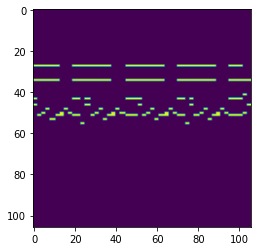

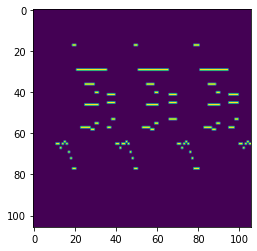

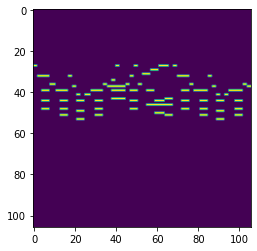

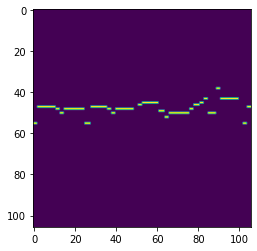

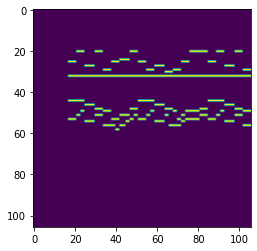

In [5]:
for i in range(len(exampleImages)):
    plt.imshow(image.array_to_img(exampleImages[i,:,:,:]))
    plt.show()

**To generate new midi images, we created a GAN network consisting of a generator (to create the new midi images) and discriminator (to determine which midi images are real or fake).**

<h5> Training the GAN Network

To train the model, we loaded 563 of the midi images into an array, and we assigned every single image in our training set a "real image" label of 1. <br><br>
We trained the model over **300** batches.<br> <br>
For every batch:
 1. We generated fake images using our generator by giving it random noise (an array of random values from -1 to 1) and the "real" class label of 1.
 
 2. Once our fake midi images were generated, we assigned a "fake" class label of 0 for each image that we generated.
 
 3. We trained the discriminator on the real images with the real labels and the fake images with the fake labels.
 
 4. Finally, we trained the generator with random noise and a target label of 1 (as if the images are real) as input  to fake off the discriminator. 
 

<h5> The Trained GAN

After training, we now have a model that is capable of generating new images from vectors of random noise.
Because training takes several minutes, we will load an already trained model to demonstrate the midi image creation. 

In [ ]:
!wget -O trained_GAN.zip https://www.dropbox.com/s/qr9b3p1xfjkqzlw/trained_GAN.zip?dl=0

In [2]:
!unzip trained_GAN.zip

Archive:  trained_GAN.zip
   creating: trained_GAN/
  inflating: trained_GAN/keras_metadata.pb  
   creating: trained_GAN/variables/
  inflating: trained_GAN/variables/variables.data-00000-of-00001  
  inflating: trained_GAN/variables/variables.index  
   creating: trained_GAN/assets/
  inflating: trained_GAN/saved_model.pb  


In [5]:
model = keras.models.load_model('./trained_GAN')

2022-05-01 00:20:46.141405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 00:20:46.141476: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 00:20:46.141526: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-efm2w): /proc/driver/nvidia/version does not exist
2022-05-01 00:20:46.141846: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Lets take a look at the GAN's architecture!

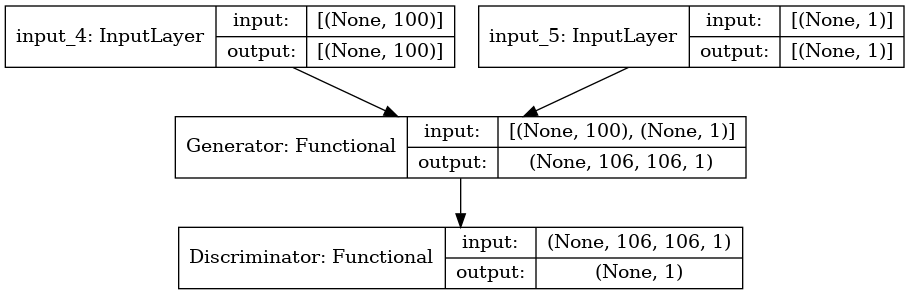

In [7]:
#to see individual generator and discriminator layers/components 
#change expand_nested=False to expand_nested=True
keras.utils.plot_model(model, show_shapes=True, expand_nested=False)

<br><br>We just need the generator from the GAN to make some images, so lets load the generator layer into a seperate variable. 

In [8]:
generator = model.get_layer(name="Generator")

TO DO 
- figure out how we need to load the trained model -- too big for GITHUB!
- generate a new image with the model (Jason) 

Now that we have generated and saved a midi image, we can use the other helper python script ([img2midi.py](https://github.com/mathigatti/midi2img)) to convert our fresh midi image into a new composition in the midi file format!